In [24]:
import os
import glob
import math
import time
import string
import random
import unicodedata
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
from torch import nn, optim
import torch.nn.functional as F

In [25]:
def find_files(path):
    return glob.glob(path)

In [26]:
find_files("datasets/names_data/names/*.txt")

['datasets/names_data/names/Czech.txt',
 'datasets/names_data/names/German.txt',
 'datasets/names_data/names/Arabic.txt',
 'datasets/names_data/names/Japanese.txt',
 'datasets/names_data/names/Chinese.txt',
 'datasets/names_data/names/Vietnamese.txt',
 'datasets/names_data/names/Russian.txt',
 'datasets/names_data/names/French.txt',
 'datasets/names_data/names/Irish.txt',
 'datasets/names_data/names/English.txt',
 'datasets/names_data/names/Spanish.txt',
 'datasets/names_data/names/Greek.txt',
 'datasets/names_data/names/Italian.txt',
 'datasets/names_data/names/Portuguese.txt',
 'datasets/names_data/names/Scottish.txt',
 'datasets/names_data/names/Dutch.txt',
 'datasets/names_data/names/Korean.txt',
 'datasets/names_data/names/Polish.txt']

In [27]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1

In [28]:
def unicode_to_ascii(word):
    return "".join(
        c
        for c in unicodedata.normalize("NFD", word)
        if unicodedata.category(c) != "Mn" and c in all_letters
    )

In [29]:
unicode_to_ascii("Ślusàrski"), unicode_to_ascii("Jalapeño")

('Slusarski', 'Jalapeno')

In [30]:
def read_lines(filename):
    lines = open(filename, encoding="utf-8").read().strip().split("\n")
    return [unicode_to_ascii(line) for line in lines]

In [31]:
category_lines = {}
all_categories = []


for filename in find_files("datasets/names_data/names/*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [32]:
category_lines["Italian"][:5]

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']

In [33]:
def category_to_tensor(category):
    category_idx = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][category_idx] = 1
    return tensor


def letter_to_index(letter):
    return all_letters.find(letter)


def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor


def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for idx, letter in enumerate(line):
        tensor[idx] = letter_to_tensor(letter)
    return tensor


def target_line_to_tensor(line):
    letter_indices = [all_letters.index(line[idx]) for idx in range(1, len(line))]
    letter_indices.append(n_letters - 1)
    return torch.LongTensor(letter_indices)


def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [34]:
print(letter_to_tensor("J"))
print(line_to_tensor("Jones").size())
print(target_line_to_tensor("Jones").size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]])
torch.Size([5, 1, 59])
torch.Size([5])


In [35]:
def random_training_pair():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    return category, line

In [36]:
def random_training_example():
    category, line = random_training_pair()
    category_tensor = category_to_tensor(category)
    line_tensor = line_to_tensor(line)
    target_tensor = target_line_to_tensor(line)
    return category_tensor, line_tensor, target_tensor

In [37]:
random_training_example()

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

In [38]:
class RNN(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
    ):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_2_hidden = nn.Linear(
            n_categories + input_size + hidden_size, hidden_size
        )
        self.input_2_output = nn.Linear(
            n_categories + input_size + hidden_size, output_size
        )
        self.output_2_output = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(
        self,
        category,
        input,
        hidden,
    ):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.input_2_hidden(input_combined)
        output = self.input_2_output(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.output_2_output(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(
        self,
    ):
        return torch.zeros(1, self.hidden_size)

In [41]:
criterion = nn.NLLLoss()
learning_rate = 5e-3
rnn = RNN(n_letters, 128, n_letters)

In [42]:
def train(
    category_tensor,
    input_line_tensor,
    target_line_tensor,
):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.init_hidden()
    rnn.zero_grad()
    loss = torch.Tensor([0])
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
    loss.backward()
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item() / input_line_tensor.size()[0]

In [44]:
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return f"{int(m)}m {int(s)}s"

In [49]:
n_iters = 100000
max_length = 20
print_every = 5000
plot_every = 1000

total_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category_tensor, line_tensor, target_tensor = random_training_example()
    output, loss = train(category_tensor, line_tensor, target_tensor)
    total_loss += loss
    if iter % print_every == 0:
        print(f"{time_since(start)}:{iter} {loss:.4f}")
    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 5s:5000 1.7643
0m 10s:10000 1.8927
0m 14s:15000 2.1931
0m 19s:20000 2.1433
0m 24s:25000 1.9721
0m 29s:30000 2.1409
0m 35s:35000 1.2303
0m 40s:40000 2.4852
0m 45s:45000 3.2010
0m 50s:50000 2.9604
0m 55s:55000 1.8826
0m 59s:60000 2.9063
1m 4s:65000 1.8387
1m 9s:70000 2.7343
1m 14s:75000 2.3397
1m 19s:80000 1.9127
1m 24s:85000 2.2816
1m 30s:90000 1.4227
1m 35s:95000 1.9622
1m 41s:100000 2.4722


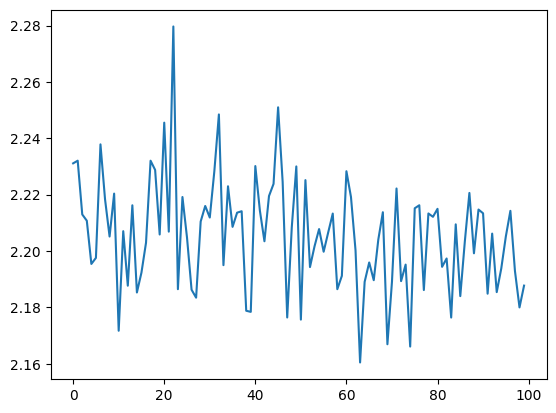

In [50]:
plt.plot(all_losses)

In [51]:
def sample(
    category,
    start_letter="A",
):
    with torch.no_grad():
        category_tensor = category_to_tensor(category)
        input_tensor = letter_to_tensor(start_letter)
        hidden = rnn.init_hidden()
        output_name = start_letter
        for i in range(max_length):
            output, hidden = rnn(category_tensor, input_tensor, hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input_tensor = letter_to_tensor(letter)
        return output_name


def samples(
    category,
    start_letters="ABC",
):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [52]:
samples("Russian", "RUS")
samples("German", "GER")
samples("Spanish", "SPA")
samples("Chinese", "CHI")

Rodhikivighinivoki
Undinhivikiv
Shimakhinivaki
Graster
Ester
Roshart
Salara
Para
Alasan
Chu
Hang
Ino
